In [ ]:
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras import layers, models


In [ ]:
num_classes = 60

In [ ]:
# Mount Google Drive to access files if necessary
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Path to your .h5 file in Google Drive
file_path1 = '/content/drive/My Drive/dataset1/NTU_CS.h5'
file_path2 = '/content/drive/My Drive/dataset1/NTU_CV.h5'


In [ ]:
# Load the NTU CS and CV datasets from .h5 files
with h5py.File(file_path1, 'r') as cs_file, h5py.File(file_path2, 'r') as cv_file:
    # List all keys in the files
    print("Keys in CS file:", list(cs_file.keys()))
    print("Keys in CV file:", list(cv_file.keys()))


Keys in CS file: ['test_x', 'test_y', 'valid_x', 'valid_y', 'x', 'y']
Keys in CV file: ['test_x', 'test_y', 'valid_x', 'valid_y', 'x', 'y']


In [ ]:
# Load the NTU CS and CV datasets from .h5 files
with h5py.File(file_path1, 'r') as cs_file, h5py.File(file_path2, 'r') as cv_file:
    # Access the datasets using the keys
    x_train_CS = np.array(cs_file['x'])
    y_train_CS = np.array(cs_file['y'])
    x_valid_CS = np.array(cs_file['valid_x'])
    y_valid_CS = np.array(cs_file['valid_y'])
    x_test_CS = np.array(cs_file['test_x'])
    y_test_CS = np.array(cs_file['test_y'])

    x_train_CV = np.array(cv_file['x'])
    y_train_CV = np.array(cv_file['y'])
    x_valid_CV = np.array(cv_file['valid_x'])
    y_valid_CV = np.array(cv_file['valid_y'])
    x_test_CV = np.array(cv_file['test_x'])
    y_test_CV = np.array(cv_file['test_y'])



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Concatenate, BatchNormalization, Activation, UpSampling2D

def dense_block(input_tensor, filters, kernel_size, stage, block, growth_rate=32):
    conv_name_base = f"res{stage}_{block}_branch"
    bn_name_base = f"bn{stage}_{block}_branch"

    x = BatchNormalization(axis=3, name=bn_name_base + '2a')(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(growth_rate, kernel_size, padding='same', name=conv_name_base + '2a')(x)

    x = Concatenate(axis=3)([input_tensor, x])

    return x

def transition_block(input_tensor, filters, stage, block):
    conv_name_base = f"res{stage}_{block}_branch"
    bn_name_base = f"bn{stage}_{block}_branch"

    x = BatchNormalization(axis=3, name=bn_name_base + '2a')(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same', name=conv_name_base + '2a')(x)
    x = MaxPooling2D((2, 2))(x)

    return x

def spatial_attention(input_tensor):
    # Compute channel-wise maximum and average pooling
    max_pool = MaxPooling2D(pool_size=(2, 2))(input_tensor)
    avg_pool = MaxPooling2D(pool_size=(2, 2))(input_tensor)

    # Upsample the spatial attention coefficients
    max_pool = UpSampling2D(size=(2, 2))(max_pool)
    avg_pool = UpSampling2D(size=(2, 2))(avg_pool)

    # Concatenate max and average pooling results
    output_tensor = Concatenate(axis=3)([max_pool, avg_pool])

    return output_tensor

def DenseNet_with_attention(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Dense block 1
    x = dense_block(x, 64, (3, 3), stage=2, block='a')
    x = dense_block(x, 64, (3, 3), stage=2, block='b')
    x = dense_block(x, 64, (3, 3), stage=2, block='c')

    # Apply spatial attention
    x = spatial_attention(x)

    # Transition block 1
    x = transition_block(x, 128, stage=3, block='a')

    # Dense block 2
    x = dense_block(x, 128, (3, 3), stage=3, block='b')
    x = dense_block(x, 128, (3, 3), stage=3, block='c')
    x = dense_block(x, 128, (3, 3), stage=3, block='d')

    # Apply spatial attention
    x = spatial_attention(x)

    # Transition block 2
    x = transition_block(x, 256, stage=4, block='a')

    # Dense block 3
    x = dense_block(x, 256, (3, 3), stage=4, block='b')
    x = dense_block(x, 256, (3, 3), stage=4, block='c')
    x = dense_block(x, 256, (3, 3), stage=4, block='d')

    # Apply spatial attention
    x = spatial_attention(x)

    # Transition block 3
    x = transition_block(x, 512, stage=5, block='a')

    # Dense block 4
    x = dense_block(x, 512, (3, 3), stage=5, block='b')
    x = dense_block(x, 512, (3, 3), stage=5, block='c')

    x = MaxPooling2D((2, 2), name='max_pool')(x)

    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax', name='fc' + str(num_classes))(x)

    model = Model(inputs=inputs, outputs=x, name='densenet_with_attention')

    return model
# Assuming your input parameters
num_classes = 60
segment_length = 300
num_features = 150

# Create the modified ResNet-50 model
input_shape = (segment_length, num_features, 1)  # Assuming grayscale images
resnet_model = DenseNet_with_attention(input_shape, num_classes)

# Print model architecture
print(resnet_model.summary())



Model: "densenet_with_attention"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 150, 1)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 150, 75, 64)          3200      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 74, 37, 64)           0         ['conv1[0][0]']               
 D)                                                                                               
                                                                                                  
 bn2_a_branch2a (BatchNorma  (None, 74, 37, 64)           256       ['max_po

In [ ]:
# Set the parameters
#num_segments = 1 # You can adjust this based on your requirements
#segment_length = 237
#num_features = 150  # Assuming each frame has 150 features


In [ ]:
print(x_train_CS.shape)

(38086, 300, 150)


In [ ]:
print(y_train_CS.shape)

(38086, 60)


In [ ]:
print(x_valid_CS.shape)

(2005, 300, 150)


In [ ]:
print(y_valid_CS.shape)

(2005, 60)


In [ ]:
print(x_test_CS.shape)

(16487, 300, 150)


In [ ]:
print(y_test_CS.shape)

(16487, 60)


In [ ]:
print(x_train_CV.shape)

(35763, 300, 150)


In [ ]:
print(y_train_CV.shape)

(35763, 60)


In [ ]:
print(x_valid_CV.shape)

(1883, 300, 150)


In [ ]:
print(y_valid_CV.shape)

(1883, 60)


In [ ]:
print(x_test_CV.shape)

(18932, 300, 150)


In [ ]:
print(y_test_CV.shape)

(18932, 60)


In [ ]:
x_train_CS = np.reshape(x_train_CS, (38086, 300, 150))


In [ ]:
x_valid_CS = np.reshape(x_valid_CS, (2005, 300, 150))

In [ ]:
x_test_CS = np.reshape(x_test_CS, (16487,1, 300, 150))

In [ ]:
# Define the Part-Aware LSTM model
num_classes = 60  # Assuming there are 60 action classes
model3_CS = DenseNet_with_attention(input_shape, num_classes)


In [ ]:
# Compile the model
model3_CS.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
#multi_cnn_model_CS.fit(x_train_CS, y_train_CS, validation_data=(x_valid_CS, y_valid_CS), epochs=150, batch_size=32)


Epoch 1/100
1191/1191 [==============================] - 82s 56ms/step - loss: 1.9766 - accuracy: 0.4611 - val_loss: 1.3214 - val_accuracy: 0.5900
Epoch 2/100
1191/1191 [==============================] - 62s 52ms/step - loss: 1.1523 - accuracy: 0.6506 - val_loss: 1.1537 - val_accuracy: 0.6618
Epoch 3/100
1191/1191 [==============================] - 62s 52ms/step - loss: 0.9242 - accuracy: 0.7137 - val_loss: 0.9715 - val_accuracy: 0.6998
Epoch 4/100
1191/1191 [==============================] - 62s 52ms/step - loss: 0.7886 - accuracy: 0.7511 - val_loss: 0.8283 - val_accuracy: 0.7531
Epoch 5/100
1191/1191 [==============================] - 62s 52ms/step - loss: 0.6730 - accuracy: 0.7843 - val_loss: 0.7450 - val_accuracy: 0.7696
Epoch 6/100
1191/1191 [==============================] - 62s 52ms/step - loss: 0.5871 - accuracy: 0.8091 - val_loss: 0.8102 - val_accuracy: 0.7561
Epoch 7/100
1191/1191 [==============================] - 62s 52ms/step - loss: 0.5055 - accuracy: 0.8348 - val_loss: 0

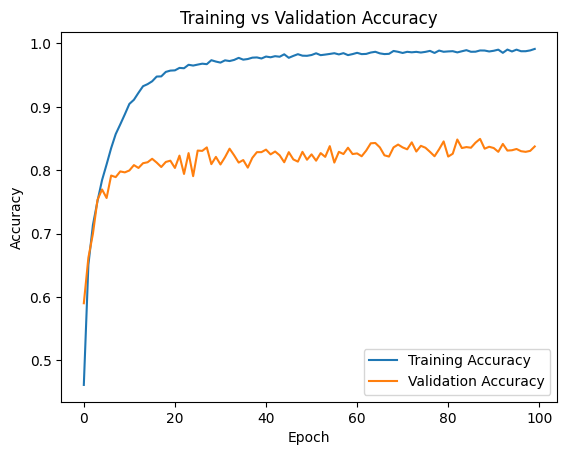

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already trained your model and have a `history` object
history = model3_CS.fit(x_train_CS, y_train_CS, epochs=100, batch_size=32, validation_data=(x_valid_CS, y_valid_CS))

# Plot training vs validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
x_test_CS = np.reshape(x_test_CS, (16487, 300, 150, 1))

In [ ]:
# Predict classes using the test data
predictions_CS = model3_CS.predict(x_test_CS)
predicted_classes_CS = np.argmax(predictions_CS, axis=1)


516/516 [==============================] - 8s 15ms/step


In [ ]:
# True classes
true_classes_CS = np.argmax(y_test_CS, axis=1)

In [ ]:
# Compare predicted classes with true classes and calculate accuracy
accuracy_CS = np.mean(predicted_classes_CS == true_classes_CS)
print("Accuracy (CS):", accuracy_CS)

Accuracy (CS): 0.7357918359919937


In [ ]:
# Print some of the predicted and true classes
print("Predicted Classes (CS):", predicted_classes_CS[:10])
print("True Classes (CS):", true_classes_CS[:10])

Predicted Classes (CS): [ 0  1  2  3 47  5  6  7  8 33]
True Classes (CS): [0 1 2 3 4 5 6 7 8 9]


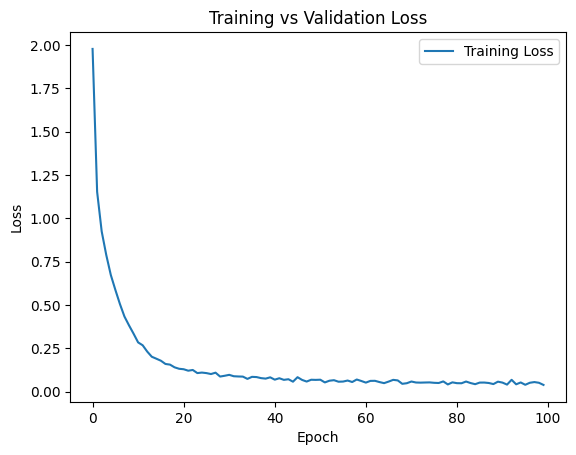

In [ ]:
import matplotlib.pyplot as plt

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [ ]:
model3_CS.save('/content/drive/My Drive/dataset1/my_model_3_cs.keras')

In [ ]:
model3_CS.save('my_model3_cs.keras')

In [ ]:
# Train the model
#multi_cnn_model_CV.fit(x_train_CV, y_train_CV, validation_data=(x_valid_CV, y_valid_CV), epochs=150, batch_size=32)
